**Deep Learnig course - Semester Project**

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases were grouped into 2 categories according the presence of tumor or not. Initially, the dataset comprised three distinct categories. For the purposes of this study, these categories were consolidated into two broader groups. This adjustment was made to enhance the interpretability of the results and to ensure a more robust analysis by reducing potential class imbalance and increasing the sample size within each group.


**1st part of analysis**
At first, the data set was slit into train and test groups and then a Convulation Neural Network was built. The CNN is comprised of 4 layers and then trained with different epochs.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
import tensorflow as tf
from PIL import Image
import os
from tensorflow.keras import layers, Sequential
from collections import Counter
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import sklearn.metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

 Data Loading & Exploratory Data Analysis

In [16]:
dataset = r'/home/konnie/lungdb'
class_folders = ['Tumor', 'Normal']
target_size = (224, 224) 
valid_extensions = ('.jpg', '.jpeg', '.png')

images = []
labels = []

for class_idx, folder_name in enumerate(class_folders):
    class_path = os.path.join(dataset, folder_name)
    
   
    class_images = [
        os.path.join(class_path, fname)
        for fname in os.listdir(class_path)
        if fname.lower().endswith(valid_extensions)
    ]
  
    for img_path in class_images:
        try:
            with Image.open(img_path) as img:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img_resized = img.resize(target_size)
                images.append(np.array(img_resized))
                labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")


images_array = np.array(images)
labels_array = np.array(labels)

print(f"Images array shape: {images_array.shape}")  
print(f"Labels array shape: {labels_array.shape}") 



Images array shape: (1097, 224, 224, 3)
Labels array shape: (1097,)


Visualize the two Classes

Found 1097 files belonging to 2 classes.
Class names: ['Normal', 'Tumor']


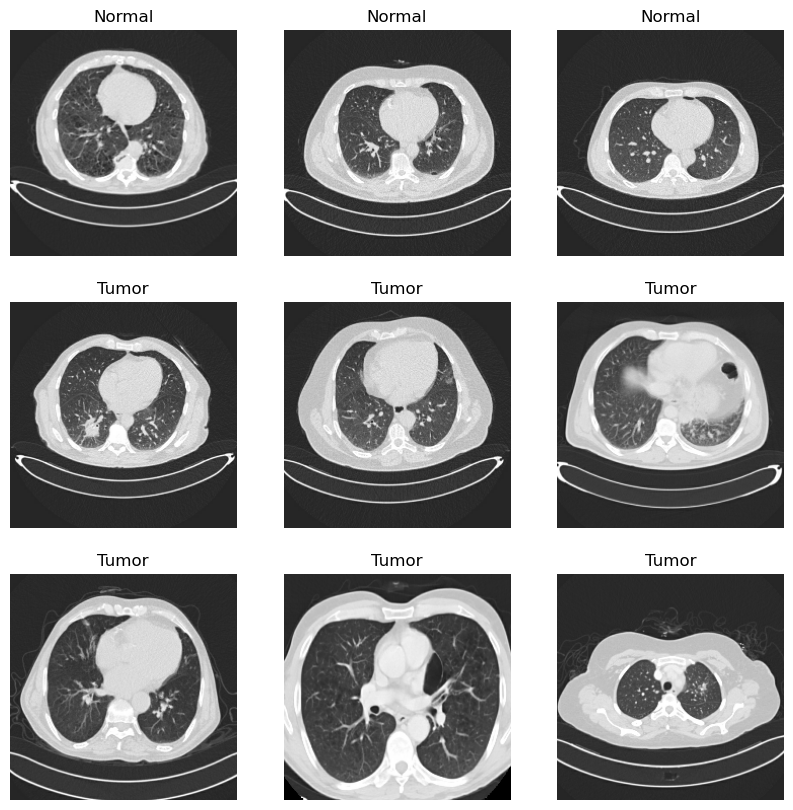

In [17]:
class_names = ['Normal case', 'Tumor case']
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

img_height, img_width = 224, 224
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset,
    labels='inferred',
    label_mode='int', 
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=42
)

class_names = train_ds.class_names
print("Class names:", class_names)


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


Split Dataset into Train and Test

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    images_array, labels_array, test_size=0.2, random_state=42)

print("The data type of the images is:", x_train.dtype)
print("The shape of the train set:", x_train.shape)
print("The shape of the test set:", x_test.shape)
print("Number of training observations:", x_train.shape[0])
print("Number of testing observations:", x_test.shape[0])
print("Train label distribution:", Counter(y_train))
print("Test label distribution:", Counter(y_test))

The data type of the images is: uint8
The shape of the train set: (877, 224, 224, 3)
The shape of the test set: (220, 224, 224, 3)
Number of training observations: 877
Number of testing observations: 220
Train label distribution: Counter({0: 543, 1: 334})
Test label distribution: Counter({0: 138, 1: 82})


Data Preprocessing - Normalization

In [19]:
print(f"Value interval of the train set before the min-max normalization:[{x_train.min()},{x_train.max()}]")
print(f"Value interval of the test set before the min-max normalization:[{x_test.min()},{x_test.max()}]")
# scale the pixels to the [0,1] range
x_train = x_train / 255.0
x_test = x_test / 255.0
print(f"Value interval of the train set after the min-max normalization:[{x_train.min()},{x_train.max()}]")
print(f"Value interval of the test set after the min-max normalization:[{x_test.min()},{x_test.max()}]")

Value interval of the train set before the min-max normalization:[0,255]
Value interval of the test set before the min-max normalization:[0,255]
Value interval of the train set after the min-max normalization:[0.0,1.0]
Value interval of the test set after the min-max normalization:[0.0,1.0]


CNN Overview

In [20]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),         
                    
    layers.Conv2D(32, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dense(2, activation="softmax")  # For 2 classes: Normal and Tumor
])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 256)      

Data Augmentation using ImageDataGenerator

In [21]:
data_augmentation = ImageDataGenerator(
    rotation_range=15,      
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    horizontal_flip=True,   
    zoom_range=0.1,         
    fill_mode='nearest',    
    validation_split=0.2    
)

Compile the model without augmentation

In [22]:
cnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Train and Validation Generator

In [23]:
# Generate training and validation flows
train_generator = data_augmentation.flow(
    x_train, y_train,
    batch_size=32,
    subset='training'
)

validation_generator = data_augmentation.flow(
    x_train, y_train, 
    batch_size=32,
    subset='validation',
    shuffle=False  # Don't shuffle validation data
)

Fitting the model

In [24]:
history_cnn1 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 32,  # 80% of data is used for training with validation_split=0.2
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 32,  # 20% of data is used for validation
)

Epoch 1/10
21/21 [==============================] - 25s 1s/step - loss: 1.0946 - accuracy: 0.4987 - val_loss: 0.6197 - val_accuracy: 0.7063
Epoch 2/10
21/21 [==============================] - 24s 1s/step - loss: 0.6677 - accuracy: 0.5821 - val_loss: 0.5744 - val_accuracy: 0.7063
Epoch 3/10
21/21 [==============================] - 24s 1s/step - loss: 0.6078 - accuracy: 0.6233 - val_loss: 0.5699 - val_accuracy: 0.6250
Epoch 4/10
21/21 [==============================] - 24s 1s/step - loss: 0.5857 - accuracy: 0.6593 - val_loss: 0.5458 - val_accuracy: 0.7375
Epoch 5/10
21/21 [==============================] - 23s 1s/step - loss: 0.6010 - accuracy: 0.6659 - val_loss: 0.5469 - val_accuracy: 0.7188
Epoch 6/10
21/21 [==============================] - 25s 1s/step - loss: 0.5875 - accuracy: 0.6625 - val_loss: 0.5866 - val_accuracy: 0.6500
Epoch 7/10
21/21 [==============================] - 23s 1s/step - loss: 0.5488 - accuracy: 0.7188 - val_loss: 0.5876 - val_accuracy: 0.6313
Epoch 8/10
21/21 [==

Accuracy and Loss plots

In [25]:
def plot_training_history(history, title):
    """Plot the training and validation accuracy/loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    
    # Loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{title} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

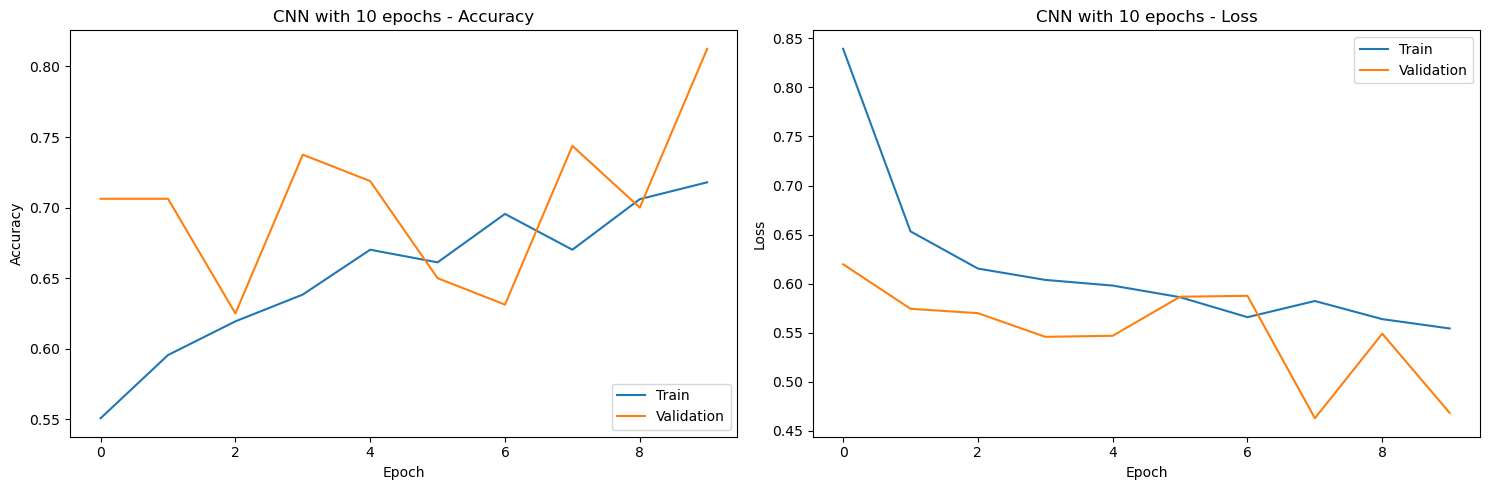

In [26]:
plot_training_history(history_cnn1, "CNN with 10 epochs")

Train the CNN with 30 epochs and plot accuracy and loss

In [27]:
history_cnn2 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 32,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 32,
)

Epoch 1/30
21/21 [==============================] - 24s 1s/step - loss: 0.5785 - accuracy: 0.7015 - val_loss: 0.4661 - val_accuracy: 0.8188
Epoch 2/30
21/21 [==============================] - 24s 1s/step - loss: 0.5377 - accuracy: 0.7418 - val_loss: 0.4073 - val_accuracy: 0.8125
Epoch 3/30
21/21 [==============================] - 24s 1s/step - loss: 0.4948 - accuracy: 0.7687 - val_loss: 0.4176 - val_accuracy: 0.8125
Epoch 4/30
21/21 [==============================] - 24s 1s/step - loss: 0.4736 - accuracy: 0.7761 - val_loss: 0.3438 - val_accuracy: 0.8438
Epoch 5/30
21/21 [==============================] - 24s 1s/step - loss: 0.5307 - accuracy: 0.7328 - val_loss: 0.5296 - val_accuracy: 0.7188
Epoch 6/30
21/21 [==============================] - 23s 1s/step - loss: 0.7233 - accuracy: 0.6284 - val_loss: 0.5286 - val_accuracy: 0.7875
Epoch 7/30
21/21 [==============================] - 24s 1s/step - loss: 0.5537 - accuracy: 0.6910 - val_loss: 0.5155 - val_accuracy: 0.7500
Epoch 8/30
21/21 [==

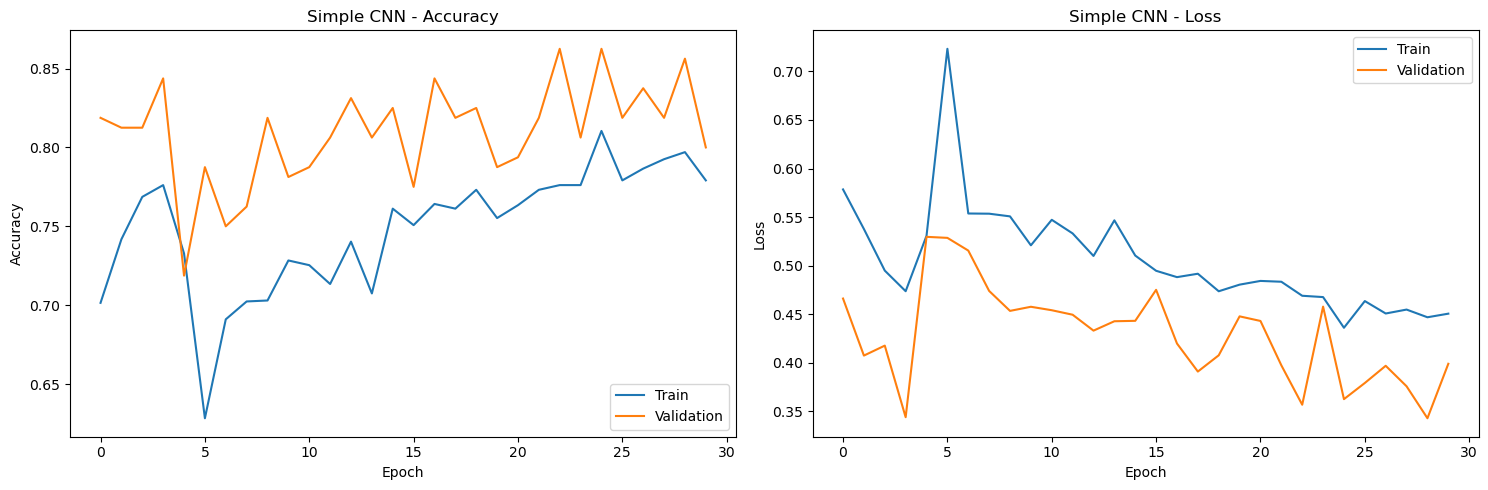

In [28]:
plot_training_history(history_cnn2, "Simple CNN")


Train the CNN with 50 epochs and plot the accuracy and loss

In [29]:
history_cnn3 = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(x_train) * 0.8 // 64,
    epochs= 50,
    validation_data=validation_generator,
    validation_steps=len(x_train) * 0.2 // 64,
)

Epoch 1/50
10/10 [==============================] - 12s 1s/step - loss: 0.4534 - accuracy: 0.7656 - val_loss: 0.4478 - val_accuracy: 0.7812
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 0.4061 - accuracy: 0.8375 - val_loss: 0.2778 - val_accuracy: 0.9219
Epoch 3/50
10/10 [==============================] - 12s 1s/step - loss: 0.4763 - accuracy: 0.7719 - val_loss: 0.3024 - val_accuracy: 0.8906
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 0.4752 - accuracy: 0.7956 - val_loss: 0.3803 - val_accuracy: 0.8125
Epoch 5/50
10/10 [==============================] - 13s 1s/step - loss: 0.4056 - accuracy: 0.8500 - val_loss: 0.3446 - val_accuracy: 0.8438
Epoch 6/50
10/10 [==============================] - 13s 1s/step - loss: 0.3867 - accuracy: 0.8302 - val_loss: 0.2885 - val_accuracy: 0.8906
Epoch 7/50
10/10 [==============================] - 13s 1s/step - loss: 0.4581 - accuracy: 0.7642 - val_loss: 0.3685 - val_accuracy: 0.7969
Epoch 8/50
10/10 [==

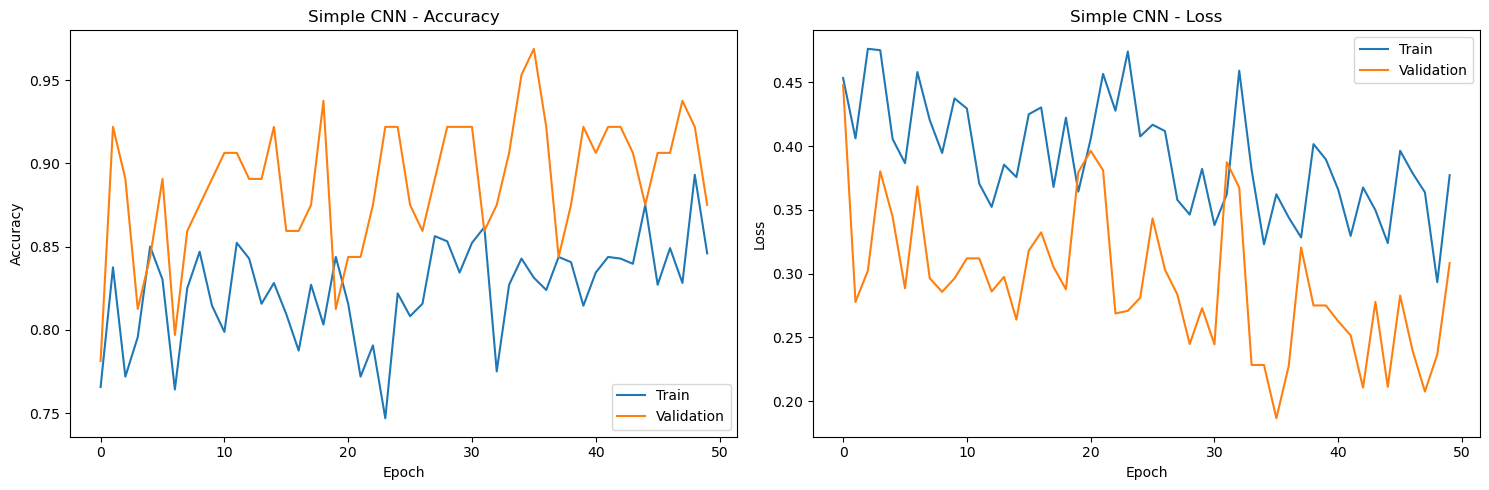

In [30]:
plot_training_history(history_cnn3, "Simple CNN")


In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_comparison(histories, names=None, figsize=(10, 6)):

    if names is None:
        names = [f"Model {i+1}" for i in range(len(histories))]
        
    plt.figure(figsize=figsize)
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, orange, green
    line_styles = ['-', '--']  # Solid for train, dashed for validation
    
    for i, history in enumerate(histories):
        # Convert to dict if it's a Keras History object
        if hasattr(history, 'history'):
            history = history.history
            
        # Plot training accuracy
        epochs = range(1, len(history['accuracy']) + 1)
        plt.plot(epochs, history['accuracy'], 
                 color=colors[i], linestyle=line_styles[0],
                 marker='o', markersize=4, 
                 label=f'{names[i]} (train)')
        
        # Plot validation accuracy
        if 'val_accuracy' in history:
            plt.plot(epochs, history['val_accuracy'], 
                     color=colors[i], linestyle=line_styles[1],
                     marker='s', markersize=4, 
                     label=f'{names[i]} (val)')
    
    plt.title('Model Accuracy Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')
    
    # Set y-axis to start from a reasonable minimum - FIXED THIS LINE
    y_vals = []
    for h in histories:
        if hasattr(h, 'history'):
            y_vals.extend(h.history['accuracy'])
        else:
            y_vals.extend(h['accuracy'])
    
    y_min = max(0, min(y_vals) - 0.05)  # Leave some margin
    plt.ylim(bottom=y_min, top=1.0)
    
    plt.tight_layout()
    plt.show()

    




The model was trained for 10, 30 and 50 epochs, and the results were evaluated using accuracy and loss plots for training and validation data. These key observations were made: 

**Training Duration:** Increasing epochs from 10 to 50 improved test accuracy from 0.918 to 0.95, with most gains occurring in early epochs.
**Performance Stability:** Shorter training (10 epochs) yielded remarkably stable learning curves, while longer training introduced significant    volatility without proportional accuracy gains.




plots comparing the training runs


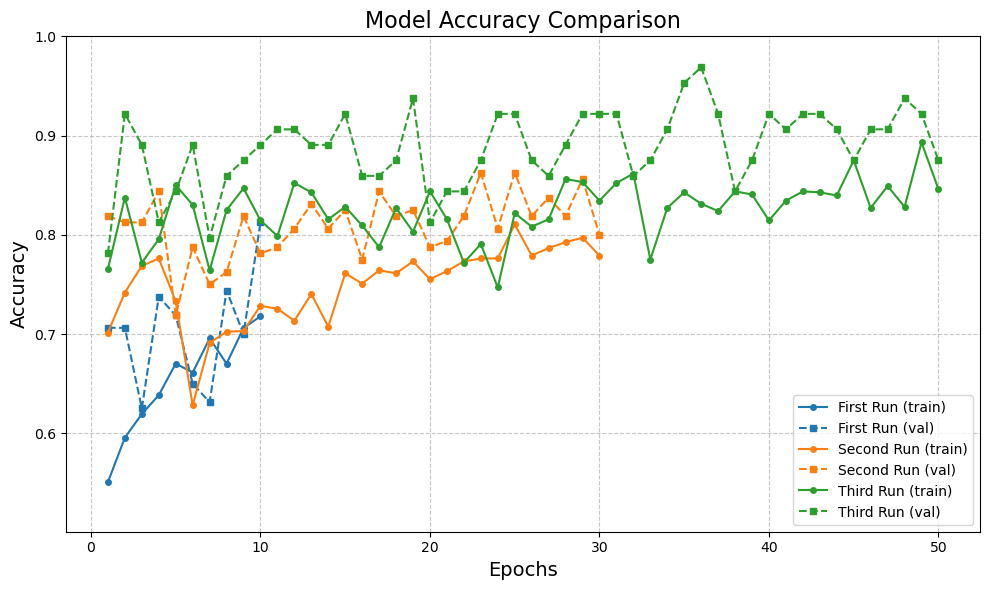

In [32]:
plot_accuracy_comparison(
    [history_cnn1, history_cnn2, history_cnn3], 
    names=['First Run', 'Second Run', 'Third Run']
)

Evaluation of the cnn model

In [34]:
# Evaluate model performance and save metrics
def evaluate_model(model, test_generator, save_results=True):
    print("Evaluating model performance...")
    
    # Run evaluation on test/validation set
    results = model.evaluate(test_generator, verbose=1)
    
    # Extract metrics
    loss = results[0]
    accuracy = results[1]
    
    # Create dictionary of all metrics
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    
    # Additional metrics if available in the model
    metrics_names = model.metrics_names
    for i, metric_name in enumerate(metrics_names):
        if metric_name not in ['loss', 'accuracy']:
            metrics[metric_name] = results[i]
    
    # Print results with nice formatting
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION")
    print("="*50)
    print(f"Loss:     {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Print additional metrics if available
    for metric_name, value in metrics.items():
        if metric_name not in ['loss', 'accuracy']:
            print(f"{metric_name}: {value:.4f}")
    print("="*50)
    
    # Save results to file if requested
    if save_results:
        import datetime
        import os
        
        # Create results directory if it doesn't exist
        if not os.path.exists('results'):
            os.makedirs('results')
            
        # Get current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
        # Save metrics to file
        with open(f'results/model_evaluation_{timestamp}.txt', 'w') as f:
            f.write("MODEL EVALUATION RESULTS\n")
            f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Loss: {loss:.6f}\n")
            f.write(f"Accuracy: {accuracy:.6f}\n")
            for metric_name, value in metrics.items():
                if metric_name not in ['loss', 'accuracy']:
                    f.write(f"{metric_name}: {value:.6f}\n")
                    
        print(f"Results saved to results/model_evaluation_{timestamp}.txt")
    
    return metrics

# Example usage
metrics = evaluate_model(cnn_model, validation_generator)

# Access individual metrics
final_accuracy = metrics['accuracy']
final_loss = metrics['loss']

print(f"Final model accuracy: {final_accuracy:.4f}")
print(f"Final model loss: {final_loss:.4f}")

Evaluating model performance...
6/6 [==============================] - 3s 451ms/step - loss: 0.3719 - accuracy: 0.8343

FINAL MODEL EVALUATION
Loss:     0.3719
Accuracy: 0.8343 (83.43%)
Results saved to results/model_evaluation_20250603-111318.txt
Final model accuracy: 0.8343
Final model loss: 0.3719


**RESNET**

In [ ]:
'''resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2, activation='softmax')(x)
model = Model(inputs=resnet_model.input, outputs=x)

In [ ]:
'''model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=10, validation_data=validation_generator)

**Efficient Net**

In [52]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

base_model = EfficientNetB0(weights='imagenet', 
                           include_top=False, 
                           input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  
num_classes = 2  # Change this to match your dataset classes (e.g., 2, 3, etc.)
predictions = Dense(1, activation='softmax')(x)


model_eff = Model(inputs=base_model.input, outputs=predictions)


Compile the model

In [54]:
model_eff.compile(
    optimizer= 'adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Early stopping & reduce learning rate 

In [ ]:
'''
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)
"""

Train the model

In [55]:
callbacks = [early_stopping, reduce_lr]

history_eff10 = model_eff.fit(
    train_generator,
    epochs= 10,
    validation_data=validation_generator,
    #callbacks = callbacks
    
)

Epoch 1/10
22/22 [==============================] - 82s 3s/step - loss: 0.6861 - accuracy: 0.4112 - val_loss: 0.6292 - val_accuracy: 0.2914
Epoch 2/10
22/22 [==============================] - 66s 3s/step - loss: 0.6743 - accuracy: 0.3998 - val_loss: 0.6327 - val_accuracy: 0.2914
Epoch 3/10
22/22 [==============================] - 72s 3s/step - loss: 0.6893 - accuracy: 0.4036 - val_loss: 0.6264 - val_accuracy: 0.2914
Epoch 4/10
22/22 [==============================] - 68s 3s/step - loss: 0.6758 - accuracy: 0.3963 - val_loss: 0.6427 - val_accuracy: 0.2914
Epoch 5/10
22/22 [==============================] - 67s 3s/step - loss: 0.6904 - accuracy: 0.4049 - val_loss: 0.6429 - val_accuracy: 0.2914
Epoch 6/10
22/22 [==============================] - 62s 3s/step - loss: 0.6812 - accuracy: 0.4156 - val_loss: 0.6147 - val_accuracy: 0.2914
Epoch 7/10
22/22 [==============================] - 68s 3s/step - loss: 0.7112 - accuracy: 0.4408 - val_loss: 0.6265 - val_accuracy: 0.2914
Epoch 8/10
22/22 [==

Plot the accuracy and loss of EfficientNet

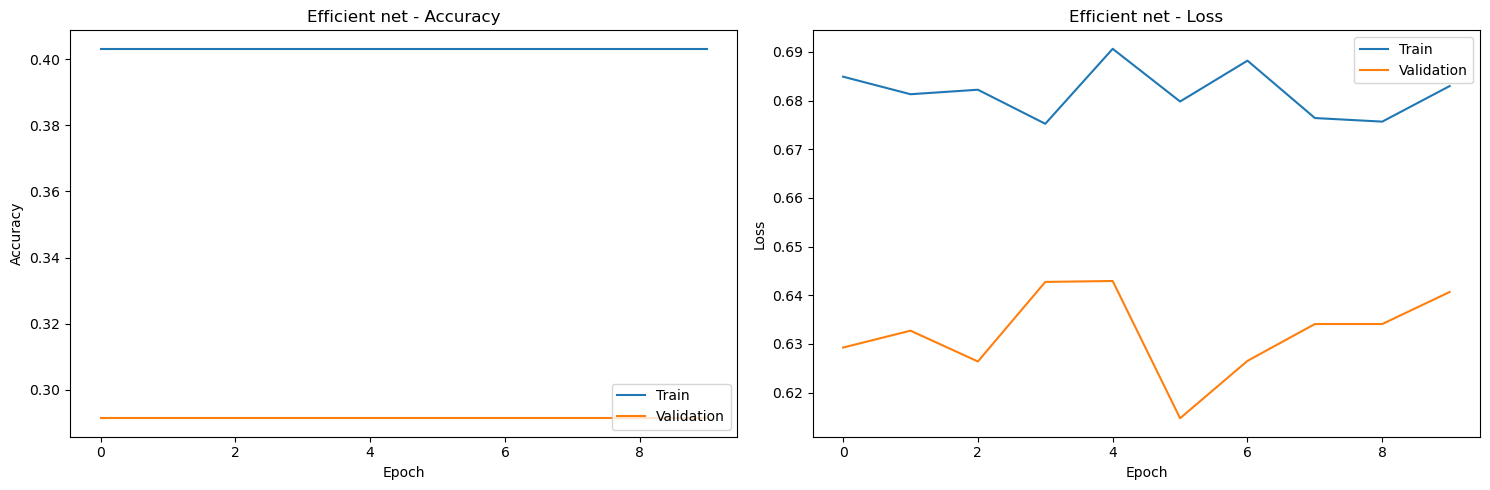

In [56]:
plot_training_history(history_eff10, "Efficient net")

Train EfficientNet with 30 epochs and plot the accuracy an dloss

In [57]:
history_eff30 = model_eff.fit(
    train_generator,
    epochs= 30,
    validation_data=validation_generator,
    #callbacks = callbacks
    
)

Epoch 1/30
22/22 [==============================] - 88s 4s/step - loss: 0.6801 - accuracy: 0.4031 - val_loss: 0.6336 - val_accuracy: 0.2914
Epoch 2/30
22/22 [==============================] - 82s 4s/step - loss: 0.6761 - accuracy: 0.4031 - val_loss: 0.6323 - val_accuracy: 0.2914
Epoch 3/30
22/22 [==============================] - 69s 3s/step - loss: 0.6771 - accuracy: 0.4031 - val_loss: 0.6283 - val_accuracy: 0.2914
Epoch 4/30
22/22 [==============================] - 99s 5s/step - loss: 0.6763 - accuracy: 0.4031 - val_loss: 0.6432 - val_accuracy: 0.2914
Epoch 5/30
22/22 [==============================] - 88s 4s/step - loss: 0.6753 - accuracy: 0.4031 - val_loss: 0.6379 - val_accuracy: 0.2914
Epoch 6/30
22/22 [==============================] - 65s 3s/step - loss: 0.6798 - accuracy: 0.4031 - val_loss: 0.6341 - val_accuracy: 0.2914
Epoch 7/30
22/22 [==============================] - 71s 3s/step - loss: 0.6804 - accuracy: 0.4031 - val_loss: 0.6473 - val_accuracy: 0.2914
Epoch 8/30
22/22 [==

In [ ]:
plot_training_history(history_eff30, "Efficient net")

Evaluate efficientnet

In [39]:
# Evaluate model performance and save metrics
def evaluate_model(model, test_generator, save_results=True):
    print("Evaluating model performance...")
    
    # Run evaluation on test/validation set
    results = model.evaluate(test_generator, verbose=1)
    
    # Extract metrics
    loss = results[0]
    accuracy = results[1]
    
    # Create dictionary of all metrics
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    
    # Additional metrics if available in the model
    metrics_names = model.metrics_names
    for i, metric_name in enumerate(metrics_names):
        if metric_name not in ['loss', 'accuracy']:
            metrics[metric_name] = results[i]
    
    # Print results with nice formatting
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION")
    print("="*50)
    print(f"Loss:     {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Print additional metrics if available
    for metric_name, value in metrics.items():
        if metric_name not in ['loss', 'accuracy']:
            print(f"{metric_name}: {value:.4f}")
    print("="*50)
    
    # Save results to file if requested
    if save_results:
        import datetime
        import os
        
        # Create results directory if it doesn't exist
        if not os.path.exists('results'):
            os.makedirs('results')
            
        # Get current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
        # Save metrics to file
        with open(f'results/model_evaluation_{timestamp}.txt', 'w') as f:
            f.write("MODEL EVALUATION RESULTS\n")
            f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Loss: {loss:.6f}\n")
            f.write(f"Accuracy: {accuracy:.6f}\n")
            for metric_name, value in metrics.items():
                if metric_name not in ['loss', 'accuracy']:
                    f.write(f"{metric_name}: {value:.6f}\n")
                    
        print(f"Results saved to results/model_evaluation_{timestamp}.txt")
    
    return metrics

# Example usage
metrics = evaluate_model(model_eff, validation_generator)

# Access individual metrics
final_accuracy = metrics['accuracy']
final_loss = metrics['loss']

print(f"Final model accuracy: {final_accuracy:.4f}")
print(f"Final model loss: {final_loss:.4f}")

Evaluating model performance...
6/6 [==============================] - 25s 2s/step - loss: 0.6917 - accuracy: 0.3057

FINAL MODEL EVALUATION
Loss:     0.6916
Accuracy: 0.2914 (29.14%)
Results saved to results/model_evaluation_20250603-111445.txt
Final model accuracy: 0.2914
Final model loss: 0.6916


**MobileNetV2**

Load the model

In [40]:
# Define image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Load the pre-trained MobileNetV2 model
base_model_mobnet = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the base model layers
base_model_mobnet.trainable = False

Build the model 

In [41]:
x = base_model_mobnet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Binary classification output
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model_mobnet = Model(inputs=base_model_mobnet.input, outputs=predictions)

Complile model

In [43]:
# Compile the model
model_mobnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model_mobnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

Add early stopping and reduction of learning rate

In [44]:
# Set up simple callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

train model

In [45]:
# Train the model
history_mobnet10 = model_mobnet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/10
22/22 [==============================] - 34s 1s/step - loss: 0.7222 - accuracy: 0.6477 - val_loss: 0.2633 - val_accuracy: 0.9029
Epoch 2/10
22/22 [==============================] - 24s 1s/step - loss: 0.3915 - accuracy: 0.8234 - val_loss: 0.2449 - val_accuracy: 0.8914
Epoch 3/10
22/22 [==============================] - 25s 1s/step - loss: 0.3564 - accuracy: 0.8445 - val_loss: 0.2735 - val_accuracy: 0.9086
Epoch 4/10
22/22 [==============================] - 24s 1s/step - loss: 0.3513 - accuracy: 0.8462 - val_loss: 0.2490 - val_accuracy: 0.9143
Epoch 5/10
22/22 [==============================] - 24s 1s/step - loss: 0.3143 - accuracy: 0.8607 - val_loss: 0.2474 - val_accuracy: 0.8857

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/10
22/22 [==============================] - 24s 1s/step - loss: 0.3479 - accuracy: 0.8470 - val_loss: 0.2641 - val_accuracy: 0.9029
Epoch 7/10
22/22 [==============================] - 24s 1s/step - loss: 0.3238

Plot the accuracy and the loss

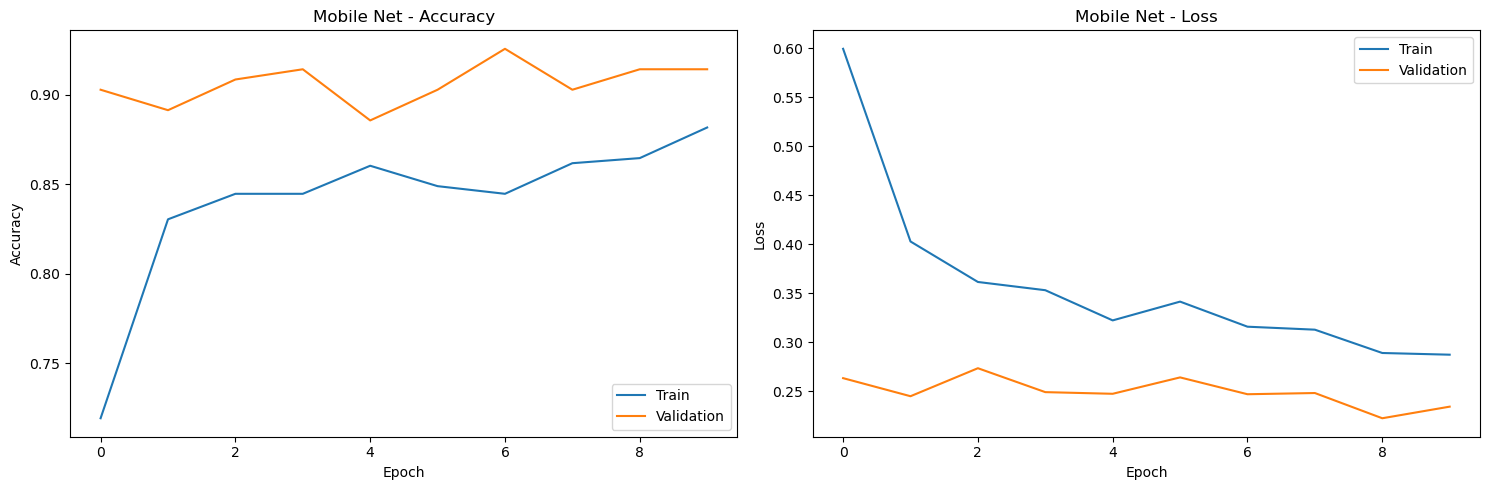

In [46]:
plot_training_history(history_mobnet10, "Mobile Net")


Train again with 30 epochs

In [47]:
# Train the model
history_mobnet30 = model_mobnet.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/30
22/22 [==============================] - 24s 1s/step - loss: 0.2998 - accuracy: 0.8661 - val_loss: 0.2282 - val_accuracy: 0.9143
Epoch 2/30
22/22 [==============================] - 26s 1s/step - loss: 0.3080 - accuracy: 0.8718 - val_loss: 0.2543 - val_accuracy: 0.9200
Epoch 3/30
22/22 [==============================] - 26s 1s/step - loss: 0.2832 - accuracy: 0.8875 - val_loss: 0.2373 - val_accuracy: 0.9143
Epoch 4/30
22/22 [==============================] - 23s 1s/step - loss: 0.2819 - accuracy: 0.8832 - val_loss: 0.2379 - val_accuracy: 0.9143

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1e-05.
Epoch 5/30
22/22 [==============================] - 24s 1s/step - loss: 0.2747 - accuracy: 0.8846 - val_loss: 0.2264 - val_accuracy: 0.9086
Epoch 6/30
22/22 [==============================] - 25s 1s/step - loss: 0.2825 - accuracy: 0.8775 - val_loss: 0.2307 - val_accuracy: 0.9257
Epoch 7/30
22/22 [==============================] - 25s 1s/step - loss: 0.3020 - accuracy: 0.86

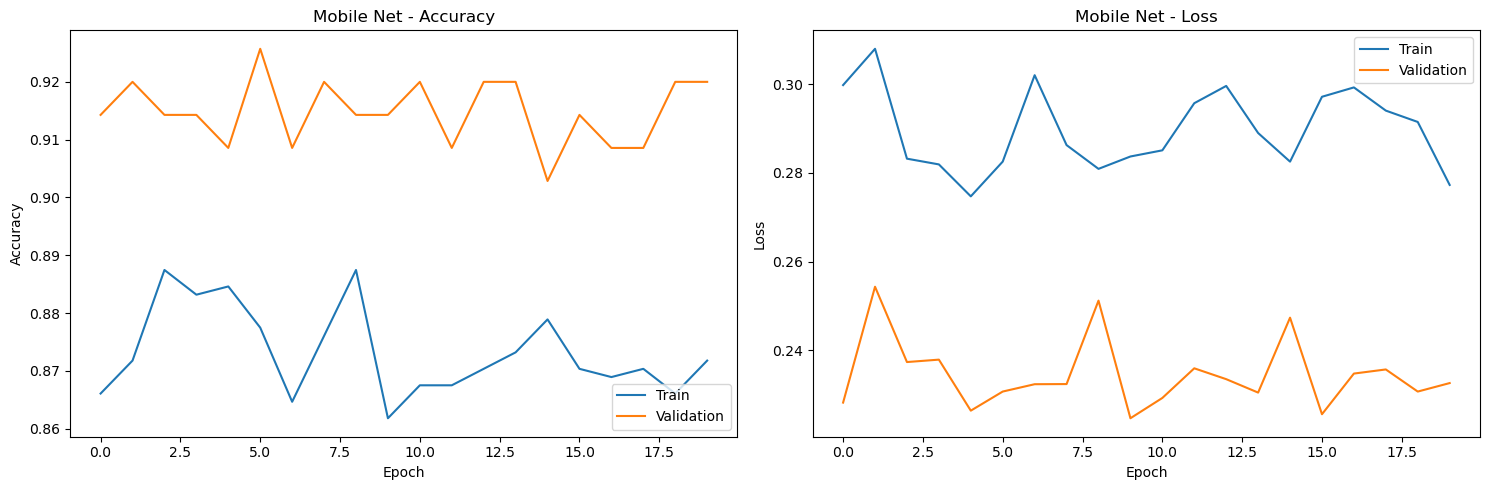

In [48]:
plot_training_history(history_mobnet30, "Mobile Net")


In [49]:
# Evaluate model performance and save metrics
def evaluate_model(model, test_generator, save_results=True):
    print("Evaluating model performance...")
    
    # Run evaluation on test/validation set
    results = model.evaluate(test_generator, verbose=1)
    
    # Extract metrics
    loss = results[0]
    accuracy = results[1]
    
    # Create dictionary of all metrics
    metrics = {
        'loss': loss,
        'accuracy': accuracy
    }
    
    # Additional metrics if available in the model
    metrics_names = model.metrics_names
    for i, metric_name in enumerate(metrics_names):
        if metric_name not in ['loss', 'accuracy']:
            metrics[metric_name] = results[i]
    
    # Print results with nice formatting
    print("\n" + "="*50)
    print("FINAL MODEL EVALUATION")
    print("="*50)
    print(f"Loss:     {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Print additional metrics if available
    for metric_name, value in metrics.items():
        if metric_name not in ['loss', 'accuracy']:
            print(f"{metric_name}: {value:.4f}")
    print("="*50)
    
    # Save results to file if requested
    if save_results:
        import datetime
        import os
        
        # Create results directory if it doesn't exist
        if not os.path.exists('results'):
            os.makedirs('results')
            
        # Get current timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
        # Save metrics to file
        with open(f'results/model_evaluation_{timestamp}.txt', 'w') as f:
            f.write("MODEL EVALUATION RESULTS\n")
            f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Loss: {loss:.6f}\n")
            f.write(f"Accuracy: {accuracy:.6f}\n")
            for metric_name, value in metrics.items():
                if metric_name not in ['loss', 'accuracy']:
                    f.write(f"{metric_name}: {value:.6f}\n")
                    
        print(f"Results saved to results/model_evaluation_{timestamp}.txt")
    
    return metrics

# Example usage
metrics = evaluate_model(model_mobnet, validation_generator)

# Access individual metrics
final_accuracy = metrics['accuracy']
final_loss = metrics['loss']

print(f"Final model accuracy: {final_accuracy:.4f}")
print(f"Final model loss: {final_loss:.4f}")

Evaluating model performance...
6/6 [==============================] - 5s 803ms/step - loss: 0.2143 - accuracy: 0.9029

FINAL MODEL EVALUATION
Loss:     0.2143
Accuracy: 0.9029 (90.29%)
Results saved to results/model_evaluation_20250603-113723.txt
Final model accuracy: 0.9029
Final model loss: 0.2143


**Compare the three models**

Plot saved as 'model_accuracy_comparison.png'


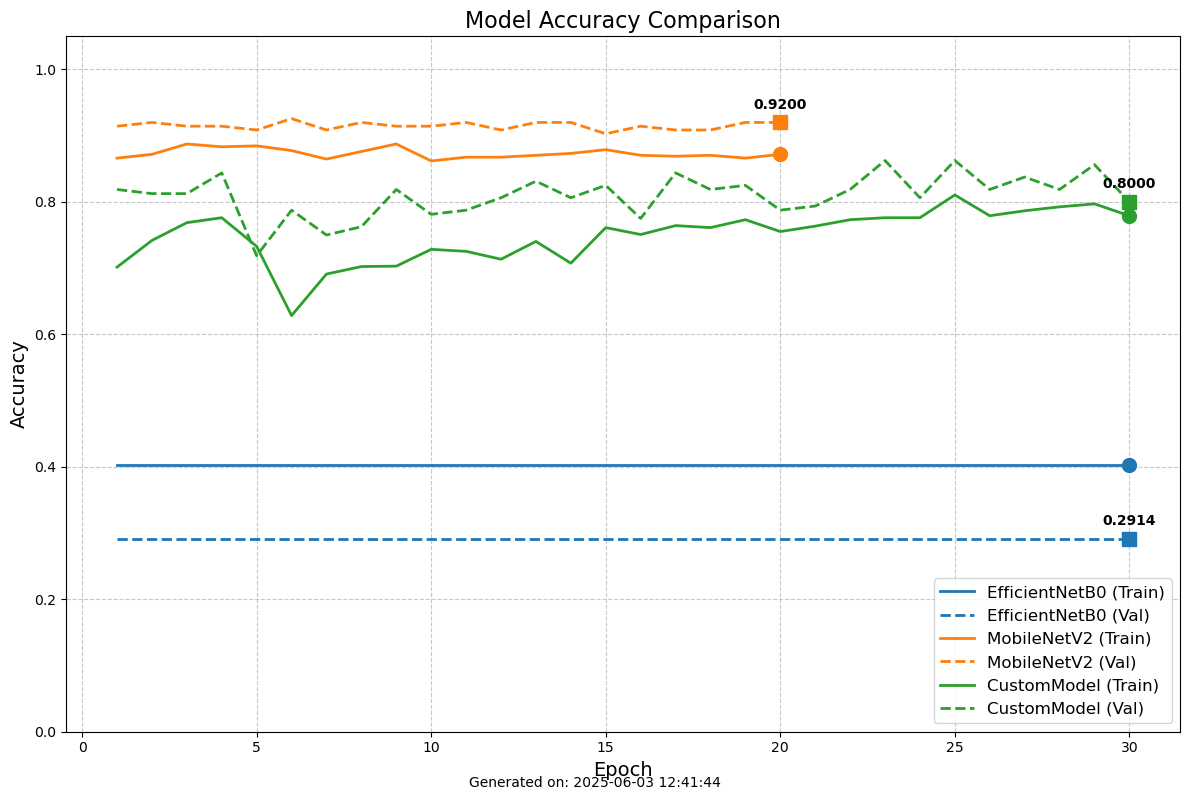


===== Model Accuracy Summary =====
         Model  Training Accuracy  Validation Accuracy  Epochs
EfficientNetB0           0.403134             0.291429      30
   MobileNetV2           0.871795             0.920000      20
   CustomModel           0.779104             0.800000      30


,Model,Training Accuracy,Validation Accuracy,Epochs
0,EfficientNetB0,0.403134,0.291429,30
1,MobileNetV2,0.871795,0.920000,20
2,CustomModel,0.779104,0.800000,30


In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

def plot_model_comparison(model_histories, model_names, save_plot=True):
    plt.figure(figsize=(12, 8))
    
    train_line_style = '-'  # solid line
    val_line_style = '--'   # dashed line
    
   
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
  
    for i, (history, name) in enumerate(zip(model_histories, model_names)):
        epochs = range(1, len(history.history['accuracy']) + 1)
       
        plt.plot(
            epochs, 
            history.history['accuracy'], 
            train_line_style,
            color=colors[i % len(colors)],
            linewidth=2,
            label=f'{name} (Train)'
        )
        
     
        plt.plot(
            epochs, 
            history.history['val_accuracy'], 
            val_line_style,
            color=colors[i % len(colors)],
            linewidth=2,
            label=f'{name} (Val)'
        )
    
   
    for i, (history, name) in enumerate(zip(model_histories, model_names)):
       
        plt.scatter(
            len(history.history['accuracy']),
            history.history['accuracy'][-1],
            s=100,
            color=colors[i % len(colors)],
            zorder=5,
            marker='o'
        )
        
      
        plt.scatter(
            len(history.history['val_accuracy']),
            history.history['val_accuracy'][-1],
            s=100,
            color=colors[i % len(colors)],
            zorder=5,
            marker='s'
        )
        
        plt.annotate(
            f"{history.history['val_accuracy'][-1]:.4f}",
            (len(history.history['val_accuracy']), history.history['val_accuracy'][-1]),
            textcoords="offset points",
            xytext=(0,10),
            ha='center',
            fontweight='bold'
        )
    
    
    plt.title('Model Accuracy Comparison', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.ylim([0, 1.05])  # Set y-axis from 0 to slightly above 1
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right', fontsize=12)
    
    # Add timestamp and summary information
    plt.figtext(
        0.5, 0.01, 
        f'Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
        ha='center', fontsize=10
    )
    
    # Improve layout
    plt.tight_layout()
    
    # Save the figure if requested
    if save_plot:
        plt.savefig('model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
        print("Plot saved as 'model_accuracy_comparison.png'")
    
    plt.show()
    
    # Create a summary table of final accuracies
    final_metrics = {
        'Model': model_names,
        'Training Accuracy': [hist.history['accuracy'][-1] for hist in model_histories],
        'Validation Accuracy': [hist.history['val_accuracy'][-1] for hist in model_histories],
        'Epochs': [len(hist.history['accuracy']) for hist in model_histories]
    }
    
    summary_df = pd.DataFrame(final_metrics)
    print("\n===== Model Accuracy Summary =====")
    print(summary_df.to_string(index=False))
    
    return summary_df

# Example usage:
# Assuming you have three model history objects: history_effnet, history_mobnet, and history_custom

# Example (replace with your actual history objects):
plot_model_comparison(
  [history_eff30, history_mobnet30, history_cnn2],
   ['EfficientNetB0', 'MobileNetV2', 'CustomModel']
 )